In [16]:
# loading necessary libraries
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from src.PostAnalysis import BinSamples
from src.PostProcessing import HuffmanEncoding
from src.NIST import nist_plot

# fixing global variables
plt.style.use("bmh")
# set the golbal figure size
rcParams["figure.figsize"] = (20, 8)
rcParams["font.size"] = 18
rcParams["font.family"] = "monospace"
rcParams["font.monospace"] = ["IBM 3270"]
rcParams['xtick.major.pad'] = 8 
rcParams['ytick.major.pad'] = 8 
rcParams["axes.labelpad"] = 40
# set the number of photos, modes, free parametres, 
# version and the number of shots
n, m, n_param, v, N = 4, 4, 5, 0, 1000000
# set the data path
data_path = "data/n{}_m{}_nparam{}_v{}".format(n, m, n_param, v)

# function definitions
def vocab_occurrenc(keyword: str) -> list:
    """
    counts the frequency of the appearance of the different binary 
    strings in a specific post-processing or encoding scheme

    input:
        keyword (str): indicates the name of the protocol, can be either 
            'vonneumann', 'huffman' or 'permuatation'
    return:
        algo_strs (list): list of all the binary strings yielded by 
            the post-processing or encoding scheme
        _ (None): plots the histogram of the frequency of the appearance 
            of the binary strings
    """
    # open the json file containing the binary strings and filter out the 
    # empty string ''
    with open("{}/{}_strs_N{}.json".format(data_path, keyword, N)) as f:
        algo_strs = json.load(f)
    algo_strs = list(filter(lambda x: x != '', algo_strs))
    # count the frequency of the appearance of the binary strings
    # and sort them in a descending order
    occurrences = Counter(algo_strs)
    total = sum(list(occurrences.values()))
    occurrences = [(key, val) for key, val in occurrences.items()]
    occurrences.sort(key=lambda x: x[1], reverse=True)
    occurrences = {el[0]: el[1]/total for el in occurrences}
    # plot the histogram
    plt.bar(list(occurrences.keys()), list(occurrences.values()))
    plt.xlabel("Binary strings")
    plt.ylabel("Probability")
    plt.xticks(rotation=90)
    plt.show()
    return algo_strs

def stat_binstream_length(bin_str_list: list, start: int, end: int, stride: int) -> dict:
    """
    extract the statistics of zero and one bits in a list of 
    binary strings
    
    input:
        bin_str_list (list): list of binary strings
        start (int): start of the range
        end (int):  end of the range
        stride (int): step size of the range 
    output:
        ratio (dict): dict of the form {index: {ratio:, dist:}}
    """
    samp = BinSamples(bin_str_list)
    trunc_indices = range(start, end, stride)
    ratio = samp.truncated_ensemble(trunc_indices=trunc_indices)
    return ratio

def zero_one_ratio(ratio_stat: dict, vonneumann: bool):
    """
    calculate the ration between zero bits and one bits
    input:
        ratio_stat (dict): dictionary containing the statistics of zero and one bits
        vonneumann (bool): if true, the xlabel of the plots shows shots/2 since 
            for von Neumann debiasing two shots are required
        return:
            _ (None): plots the ration between zero and one bits at different
                lengths of binary stream
    """
    zero_one_diff = [ratio_stat[key]["ratio"]["0"]/ratio_stat[key]["ratio"]["1"] for key in ratio_stat.keys()]
    plt.plot(list(ratio_stat.keys()), zero_one_diff, '-o')
    plt.ylabel("ratio of the number of 0's to the number of 1's\nin a continuous binary stream")
    if vonneumann:
        plt.xlabel("#Shots/2")
    else:
        plt.xlabel("#Shots")
    plt.show()

## Boson Sampling using _fock_ backend
### Architecture
The architecture of the Boson Sampler (BS) used throughout this study is as follows

<p align="center">
<img src="figs/architecture.png"
     alt="Boson Sampler Architecture"/>
</p>

It has four modes and four photons entering from the left side (shown in red circles). The beam splitters are shown in yellow rectangles and have their transmittivity $\theta$ set is to $\pi/4$ and phase angle $\phi$ to $0$. The photodetectors are shown as blue semi-circles on the right hand side.

The exact solution of the probabilities of the Fock states for the BS shown above is depicted in the following figure.

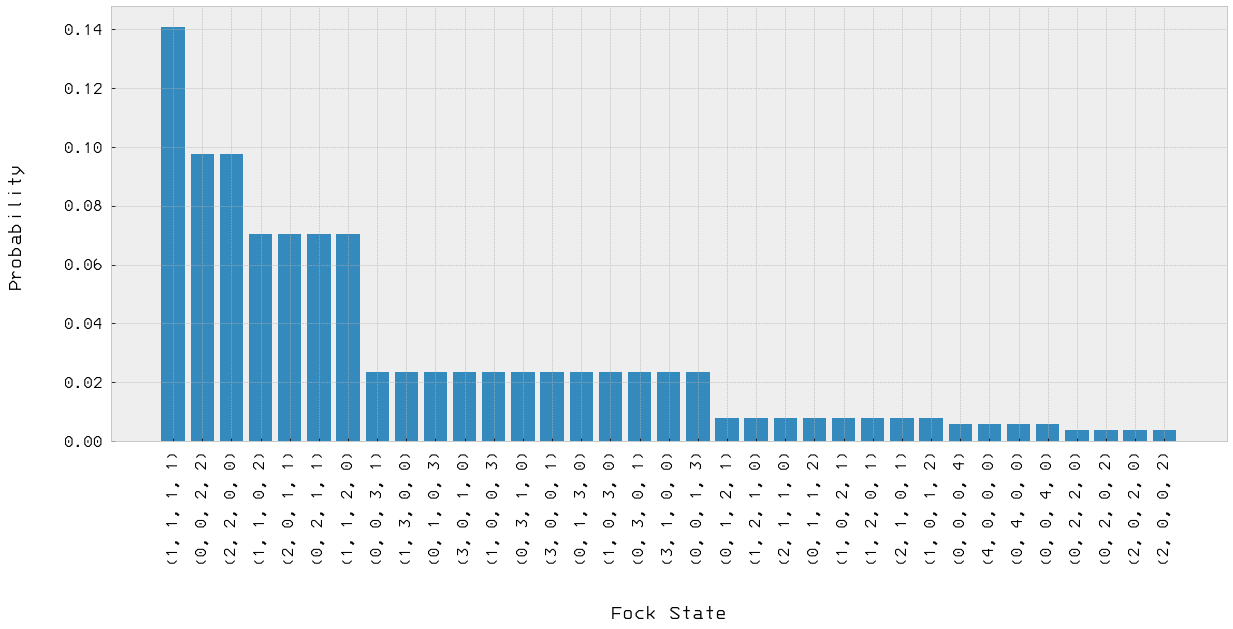

In [29]:
with open("{}/exact_result.json".format(data_path), "r") as f:
    fock_dist = json.load(f)

plt.bar(list(fock_dist.keys()), list(fock_dist.values()))
plt.ylabel("Probability")
plt.xlabel("Fock State")
plt.xticks(rotation=90);

## Simulation
The simulation was carried out on the BS shown above. The simulation parameters are $n=4$ number of photons, $m=4$ number of modes, $param=5$ number of beam splitters (basically number of transmittivity angles to be defined), $v=0$ which stands on variant of the BS and the numbor of shots $N=10^6$. The simulation was carried out by the _strawberryfields_ library developed by Xanadu using the _fock_ backend.

### Von Neumann Post-Processing
The von Neumann debiasing discussed in [[1]](https://arxiv.org/abs/2206.02292) takes two sampled Fock states and convert them to a binary string e.g. consider the Fock states _(0, 2, 0, 2)_ and _(0, 0, 0, 4)_, initially convert them to their binary representations are _(0, 1, 0, 1)_ and _(0, 0, 0, 1)_ respectively and then apply the following protocol bitwise.

bit 1 | bit 2 | output
----- | ----- | ------
  0   |   0   |   *
  0   |   1   |   0
  1   |   0   |   1
  1   |   1   |   *

Where _*_ stands on discarded. Hence for the two Fock states above, the binary string yielded after the application of the von Neumann debiasing is _\*1\*\*_ which simplifies to _1_. With $10^6$ shots, $10^6/2$ binary strings are generated using von Neumann protocol. The histogram of these binary strings is shown below.

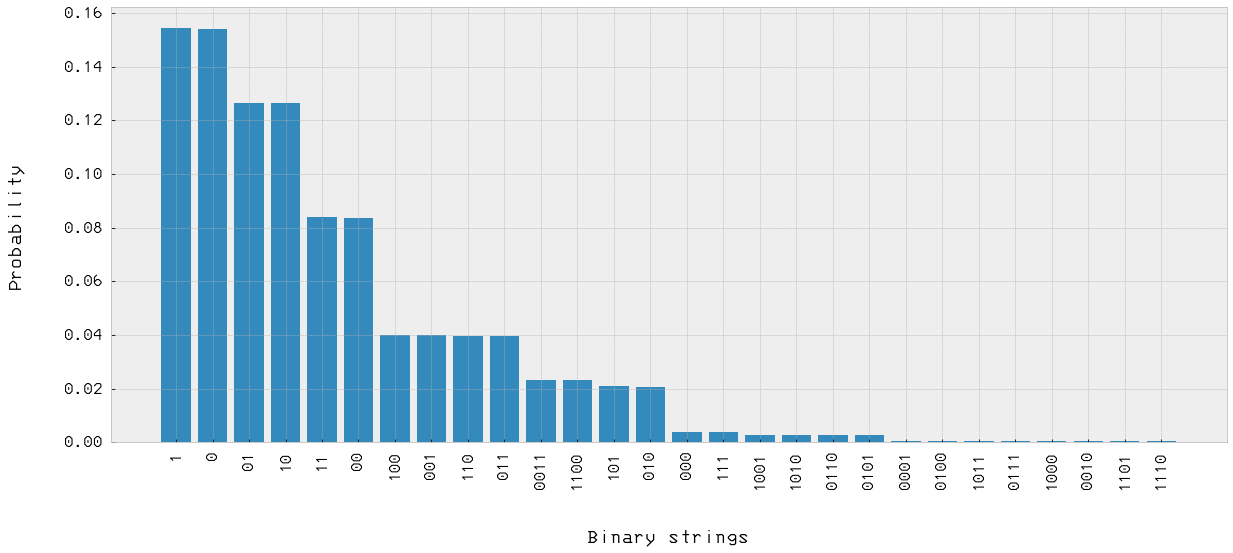

In [18]:
vonneumann_strs = vocab_occurrenc("vonneumann")

After certain number of shots, a bit stream of a specific length is yielded if we concatenate all the binary strings yielded by the von Neumann debiasing protocol. The length of stream cannot be determined since the von Neumann protocol is non-deterministic and the length of the binary string varies depending on the two input Fock states. At each shot, we can determine the ratio between the number of $0$ digits to the number of $1$ digits. This ratio tends to unity as the number shots increases (see figure below).

In [4]:
neumann_ratio = stat_binstream_length(vonneumann_strs, 1000, len(vonneumann_strs), 10000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-2)]: Done  80 out of  90 | elapsed:   12.9s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:   14.2s finished


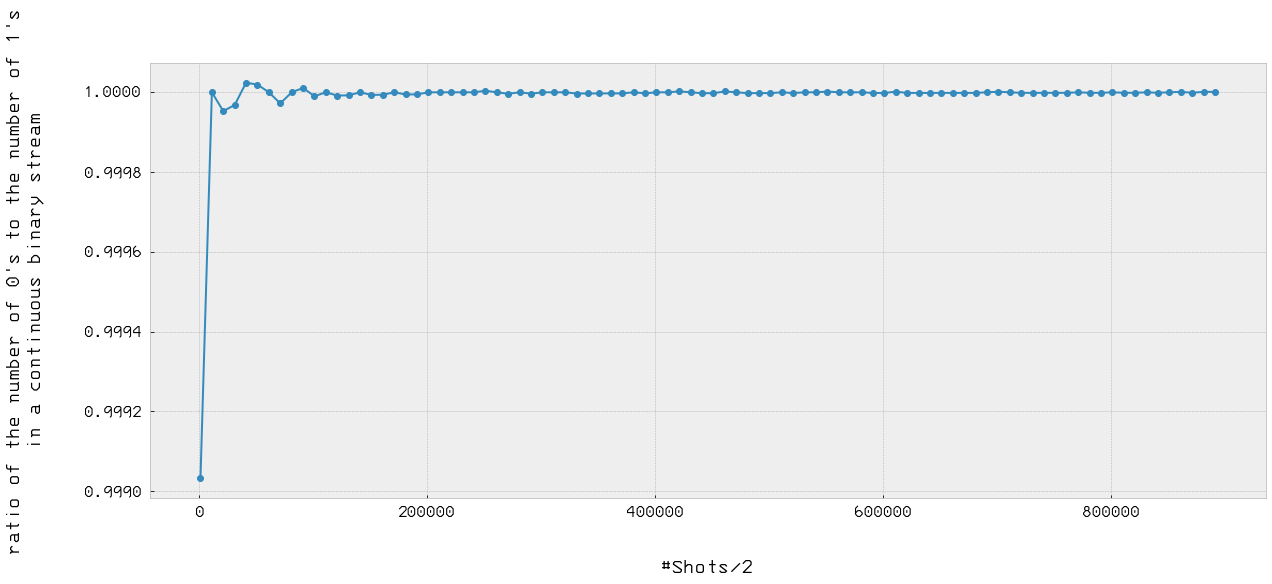

In [30]:
zero_one_ratio(neumann_ratio, True)

Sampling $10^6$ Fock states resulted in a binary stream of length $1.818373\times10^6$ that is $1.8MB$ in size. We ran the NIST SP800-22 Statistical Test Suit (NIST STS) against this binary stream by partitioning this binary stream into $110$ binary strings of length $2^{14}$. The reader is advised to refer to the __README.md__ file __NIST Statistical Test Suit (STS)__ section for further reading.

The result of the various tests is shown in the following figure.

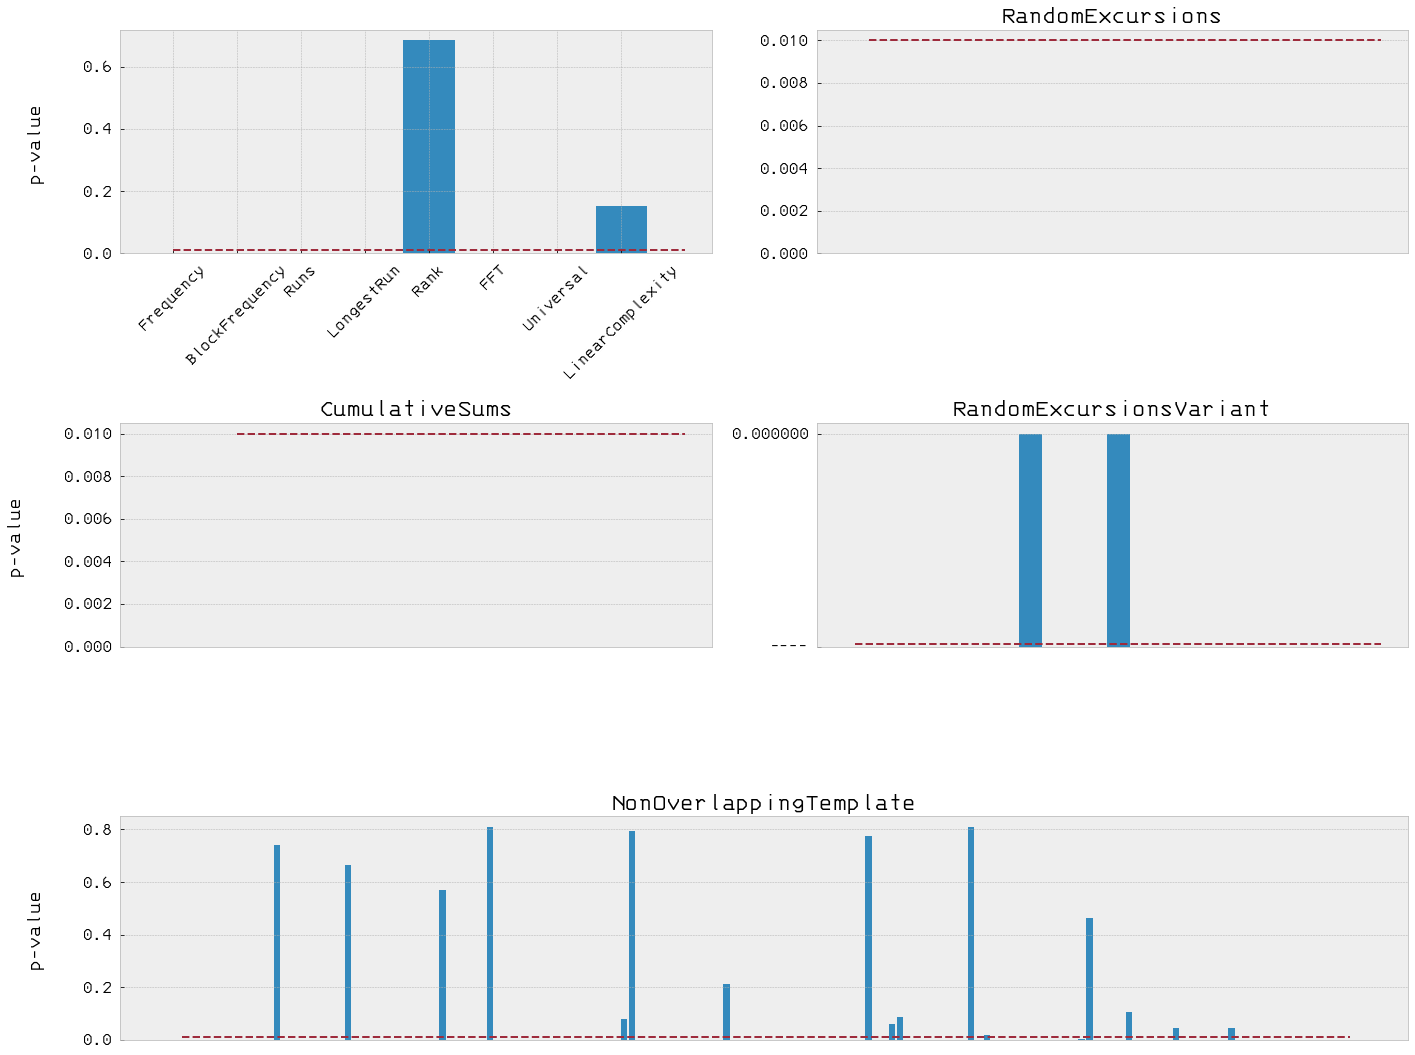

In [32]:
rcParams["figure.figsize"] = (20, 15)
nist_plot(n, m, n_param, v, "vonneumann")
rcParams["figure.figsize"] = (20, 8)

It is evident that majority of the bit strings do not pass the statistical tests provided by the NIST STS. This implies that the random binary strings generated by applying the post-processing of the von Neumann debiasing on the sampled Fock states does not meet the criteria of a good random number generator (RNG). Besides this there are serious disadvantages regarding this protocol. First of all, the length of the binary string generated after applying this protocol on two input Fock states is not fixed. Secondly, it wastes an extra Fock state to generate one binary string. This reduces the throughput of the protocol. Moreover, when the number of modes $m$ increases, more operation is required i.e. $m$-bit operation is required to get a binary string. To overcome these shortcomings, in the next section we introduce another protocol based on an Encoding scheme.

### Huffman Encoding of the Fock states
In this approach, we encode the Fock states onto a set of binary codewords using the Huffman encoding scheme (see Ref[[2]](https://link.springer.com/book/9780387947044)). Huffman encoding of a set of symbols (here the Fock states) over a probability measure ensures the smallest average codeword length. The disadvantage of this approach is that it requires prior knowledge of the probability distribution of the Fock states. Yet, to some extend we can overcome this issue by actually sampling the Fock states using a real Quantum BS for long enough time such that the probability distribution of the Fock states is know by confidence.

Assuming the probability distribution of the Fock states is known (here we simulated the exact state of th BS), the Huffman encoding scheme yields the following codewords for the BS considered above.

In [33]:
with open("data/n4_m4_nparam5_v0/exact_result.json", "r") as f:
    fock_probs = json.load(f)
huff_enc = HuffmanEncoding(fock_probs)
huff_enc.huffman_encoding()
print({key: val[0] for key, val in huff_enc.encoding.items()})

{'(1, 1, 1, 1)': '101', '(0, 0, 2, 2)': '001', '(2, 2, 0, 0)': '010', '(1, 1, 0, 2)': '1100', '(2, 0, 1, 1)': '1101', '(0, 2, 1, 1)': '1000', '(1, 1, 2, 0)': '1001', '(0, 0, 3, 1)': '01101', '(1, 3, 0, 0)': '01100', '(0, 1, 0, 3)': '00010', '(3, 0, 1, 0)': '00011', '(1, 0, 0, 3)': '00001', '(0, 3, 1, 0)': '111111', '(3, 0, 0, 1)': '00000', '(0, 1, 3, 0)': '111110', '(1, 0, 3, 0)': '111100', '(0, 3, 0, 1)': '111011', '(3, 1, 0, 0)': '111010', '(0, 0, 1, 3)': '111001', '(0, 1, 2, 1)': '1110000', '(1, 2, 1, 0)': '0111111', '(2, 1, 1, 0)': '0111110', '(0, 1, 1, 2)': '0111101', '(1, 0, 2, 1)': '0111100', '(1, 2, 0, 1)': '0111011', '(2, 1, 0, 1)': '0111010', '(1, 0, 1, 2)': '0111000', '(0, 0, 0, 4)': '11110111', '(4, 0, 0, 0)': '11110110', '(0, 4, 0, 0)': '11110101', '(0, 0, 4, 0)': '11110100', '(0, 2, 2, 0)': '11100011', '(0, 2, 0, 2)': '01110011', '(2, 0, 2, 0)': '11100010', '(2, 0, 0, 2)': '01110010'}


It is obvious if we simply encod a sequence of Fock states and convert them to their binary representation, the final stream of the binary string is biased. To elaborate this and justify further, take the most probable Fock state which is (1, 1, 1, 1). This Fock state is encoded by $101$ codeword which is already biased with 2/3 in favour of the bit $1$. Eventually, sampling more and more of this Fock state produces an enormous bias of the bit $1$. To resolve this issue, we can flip the bits of the codewords every time we use them. For instance, the first time we use $101$ to encode the Fock state (1, 1, 1, 1), for the next time when we sample this very Fock state we flip the bits and use the $010$ codeword. This way, we ensure that we remove the bias in the long run.

Figure below shows that using this trick, the probability of the appearance of a given codeword is as high as its flipped twin therefore guaranteeing equally probable number of digit $1$ and $0$. 

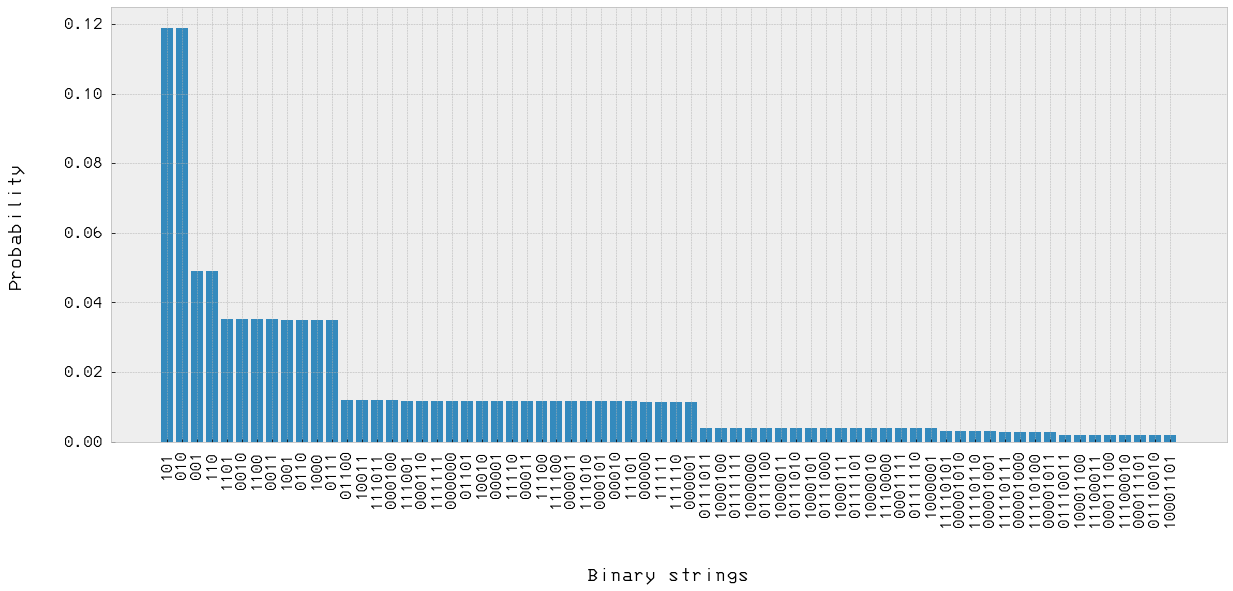

In [34]:
huffman_strs = vocab_occurrenc("huffman")

In [9]:
huffman_ratio = stat_binstream_length(huffman_strs, 1000, len(huffman_strs), 10000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-2)]: Done  92 out of 100 | elapsed:   21.2s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   23.0s finished


We clearly observe as well that the ration between the number of $0$ digits and the number of $1$ digits converges to unity after almost sampling $10^5$ Fock states.

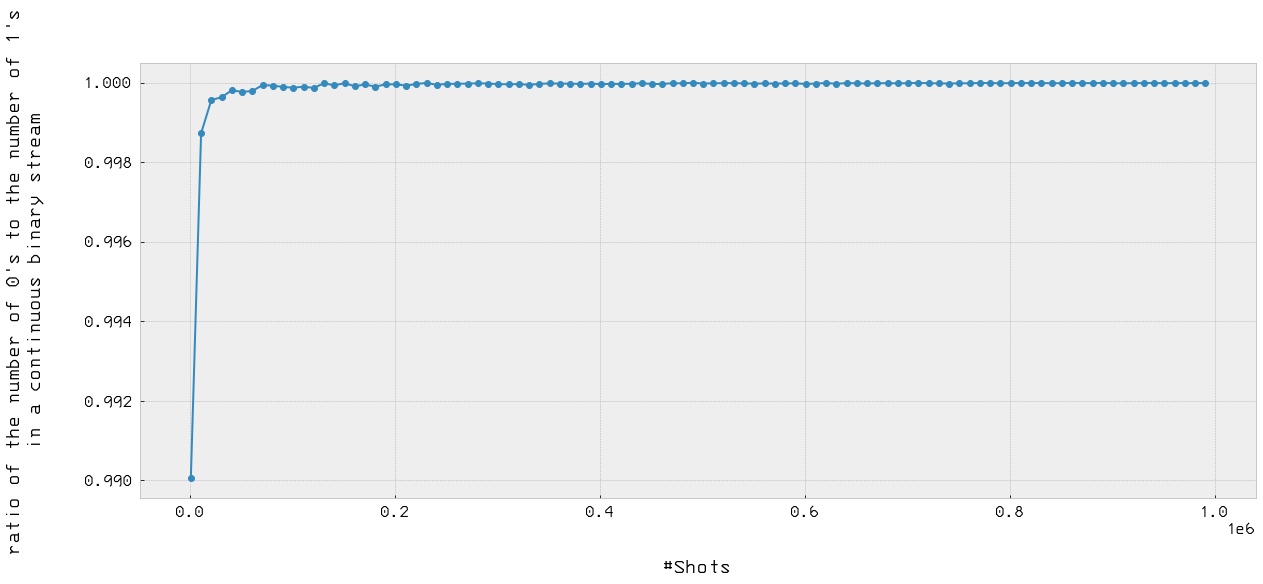

In [35]:
zero_one_ratio(huffman_ratio, False)

The convergence to unit ratio exhibits a more smoother transition in this case compared to the von Neumann debiasing protocol. In addition, after $10^6$ shots the binary stream yielded by this encoding has $4431622$ bits i.e. it is $4.3MB$ in size. This is almost $2.4$ times greater than what the von Neumann procedure yielded.

After partitioning this binary stream into $270$ binary strings of length $2^{14}$, the NIST STS produces the following results

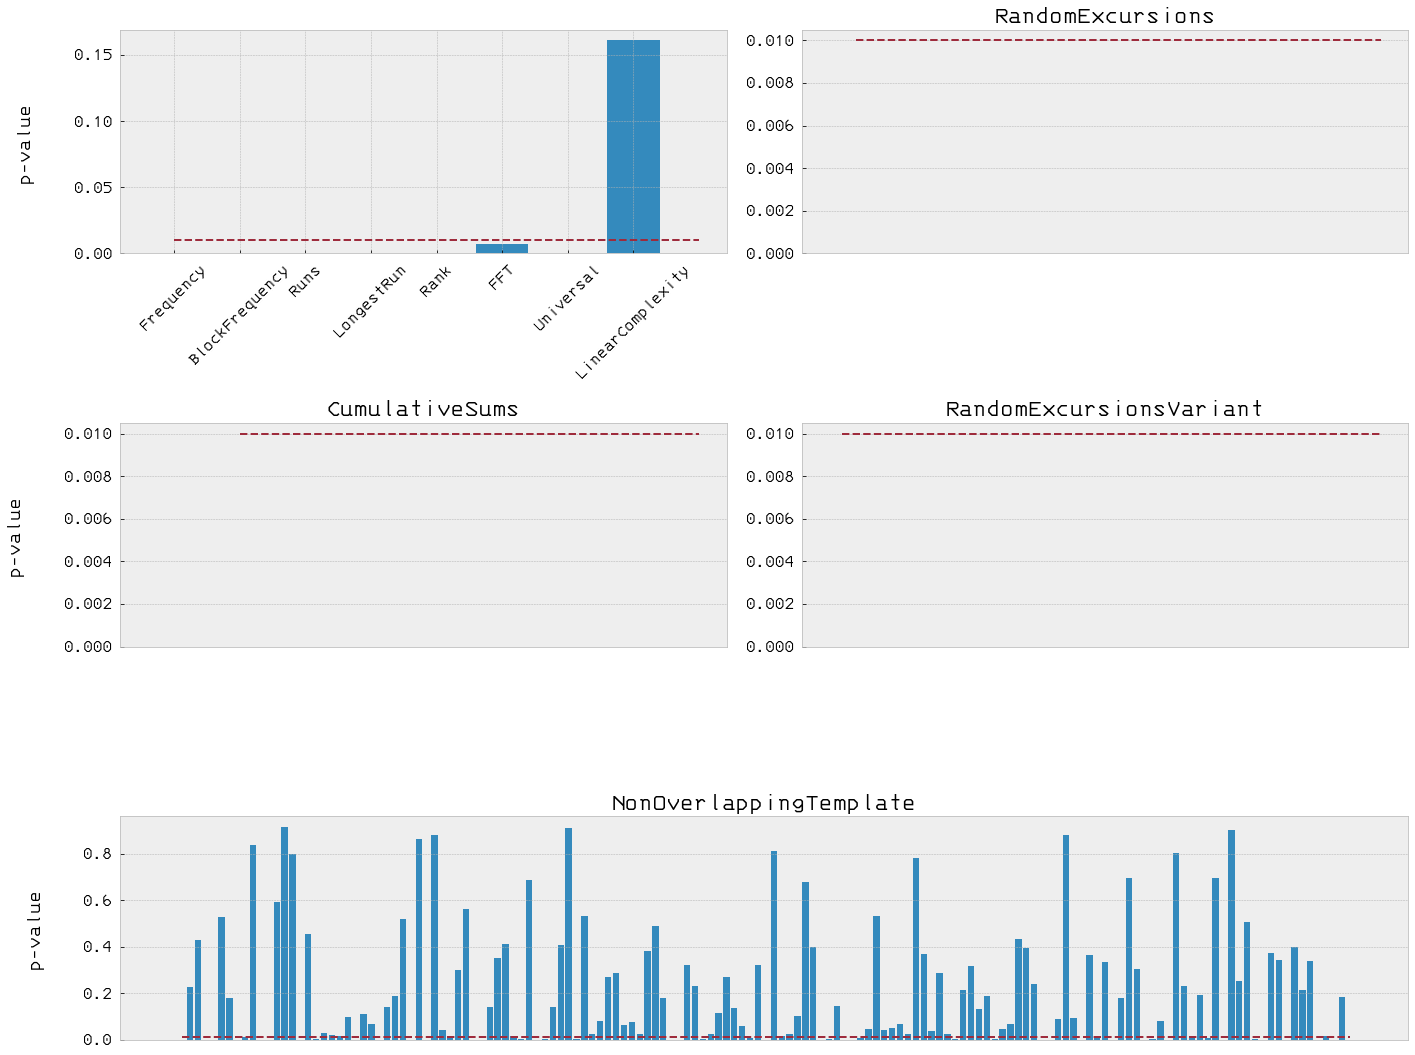

In [36]:
rcParams["figure.figsize"] = (20, 15)
nist_plot(n, m, n_param, v, "huffman")
rcParams["figure.figsize"] = (20, 8)

Although the results are still very poor, there is a huge improvement in the _Non-overlapping Template_ test compared to the earlier protocol. Moreover, there is a twofold increase in the bit-rate compared to the von Neumann protocol. Additionally, by introducing this encoding, the bit-wise operation on two input Fock states is substituted by a single dictionary lookup query, saving enormous amount of operation when generating large number of random numbers.

In the following section, another encoding is proposed based on the permutation symmetry in the architecture of the BS.


### Degenerate Fock States, Unitary Haar Matrix and Permutation Symmetry

The two previous methods to generate random binary strings had their shortcomings and more importantly, both failed to pass the NIST STS. Although when using the Huffman encoding protocol we achieved a relatively better result in the statistical tests, yet the biggest disadvantage this approach bears is the fact that the probability distribution of the Fock states must be known in the first place. It is only by knowing this piece of information that we can construct the Huffman encoding scheme.

The approach that is proposed in this section, neither requires the prior knowledge of the probability of the Fock states, nor has the problem of indeterminism in von Neumann debiasing or the waste of the samples and the extra bit-wise operation to generate the bit strings.

When the architecture of the BS admits certain symmetries, such as the one presented above, the outcome Fock states of the BS form degenerate classes i.e. we can create a disjoint partitions over the whole space spanned by the allowed Fock states. By looking at the figure that depicts the probabilities of the Fock states, we observe that some of the them have the same outcome probability. The architecture devised above, admits even-order permutation in the sense depicted in the figure below

<p align="center">
<img src="figs/permutation.png"
     alt="Permutation Symmetry"/>
</p>


The group elements are generated by swapping the first two modes and then simultaneously swapping the second two modes. The next element is achieved by swapping the first two modes by the second two modes. This procedure generates all the group elements of a single the degenerate class givin a single Fock state. For the BS architecture given above we have the following group partitions

$$
G_1 = \{(0, 2, 1, 1), (2, 0, 1, 1), (1, 1, 2, 0), (1, 1, 0, 2)\}\\
G_2 = \{(0, 0, 3, 1), (0, 0, 1, 3), (1, 3, 0, 0), (3, 1, 0, 0)\}\\
G_3 = \{(0, 1, 0, 3), (1, 0, 3, 0), (3, 0, 1, 0), (0, 3, 0, 1)\}\\
G_4 = \{(1, 0, 0, 3), (0, 1, 3, 0), (3, 0, 0, 1), (0, 3, 1, 0)\}\\
G_5 = \{(0, 1, 2, 1), (1, 0, 1, 2), (1, 2, 1, 0), (2, 1, 0, 1)\}\\
G_6 = \{(2, 1, 1, 0), (1, 2, 0, 1), (0, 1, 1, 2), (1, 0, 2, 1)\}\\
G_7 = \{(0, 0, 0, 4), (0, 0, 4, 0), (4, 0, 0, 0), (0, 4, 0, 0)\}\\
G_8 = \{(0, 2, 2, 0), (2, 0, 0, 2), (0, 2, 0, 2), (2, 0, 2, 0)\}\\
G_9 = \{(1, 1, 1, 1)\}
$$

The order of $G_i$'s is four, except for $G_9$ which is a singleton and is idempotent and its element remains invariant under permutation. Within each group $G_i$, since the states are degenerate, we can assign cyclicly the digit _0_ and _1_ to the elements within that group e.g. take $G_1$ and define the following map

$$
(0, 2, 1, 1) \rightarrow 0\\ 
(2, 0, 1, 1) \rightarrow 1\\
(1, 1, 2, 0) \rightarrow 0\\
(1, 1, 0, 2) \rightarrow 1
$$

Since each element in $G_1$ is equally probable to be observed, it is guaranteed that any sequence generated by these Fock states generate a binary string that has the same ratio of the $0$ and $1$ bits. Similarly, for all other $G_i$' we establish a similar map except for $G_9$ where the Fock state $(1, 1, 1, 1)$ is mapped to the empty string $\emptyset$ (we can of course use the trick we used in the Huffman encoding and cyclicly assign the bit $0$ and $1$ to this Fock state).

Figure below clearly depicts the fact that the $0$ bits are as probable as the $1$ bits to appear in bit strings.

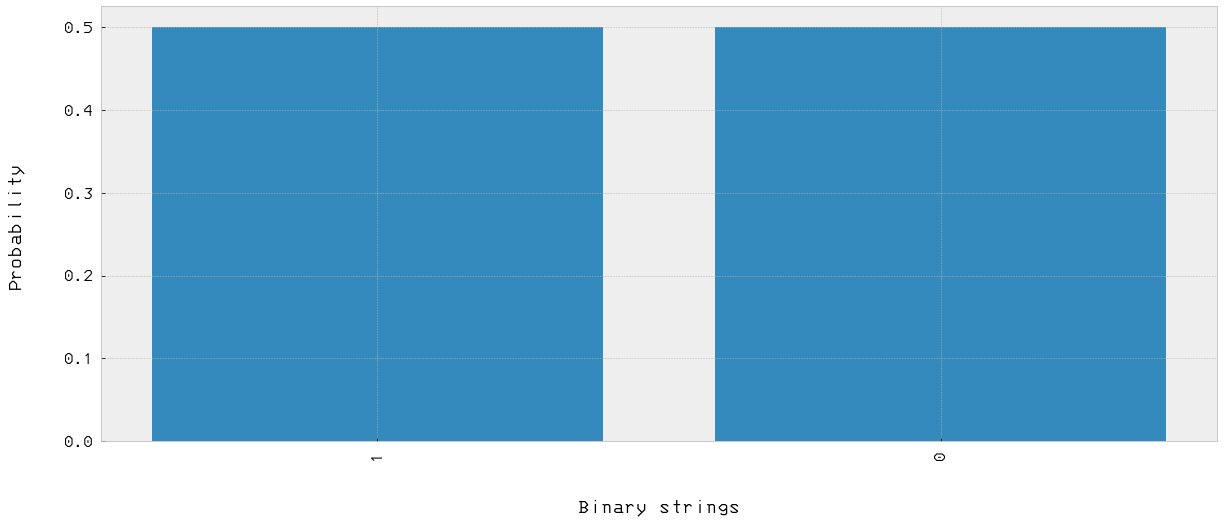

In [37]:
permutation_strs = vocab_occurrenc("permutation")

In [13]:
permutation_ratio = stat_binstream_length(permutation_strs, 1000, len(permutation_strs), 10000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  54 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  57 out of  86 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  75 out of  86 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  86 out of  86 | elapsed:    1.2s finished


And after almost $10^5$ shots, the ratio reaches unity asymptotically.

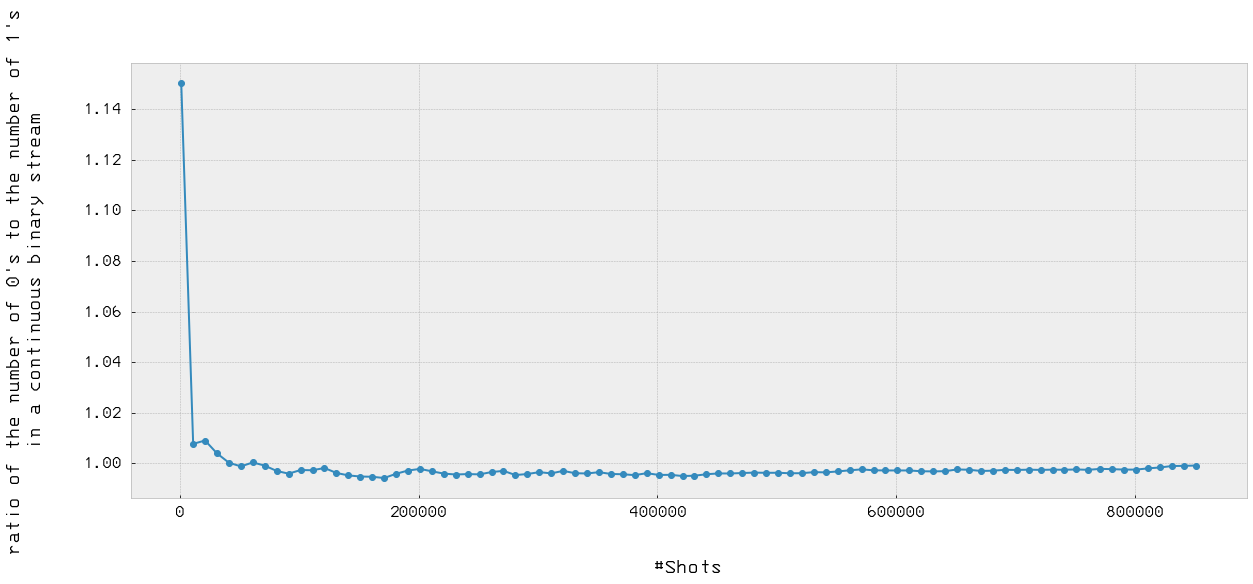

In [26]:
zero_one_ratio(permutation_ratio, False)

Astonishingly, this protocol passes almost all the NIST STS except the _Random Excursions_ and _Random Excursions Variant_ tests. The binary stream yielded after sampling $10^6$ Fock states, is $8.59177\times10^5$ which is $840KB$ in size. This is significantly smaller than the two previous protocols. Nonetheless, segmenting this binary stream into $52$ bit strings of length $2^{14}$ yields the following results for the statistical tests in NIST STS.

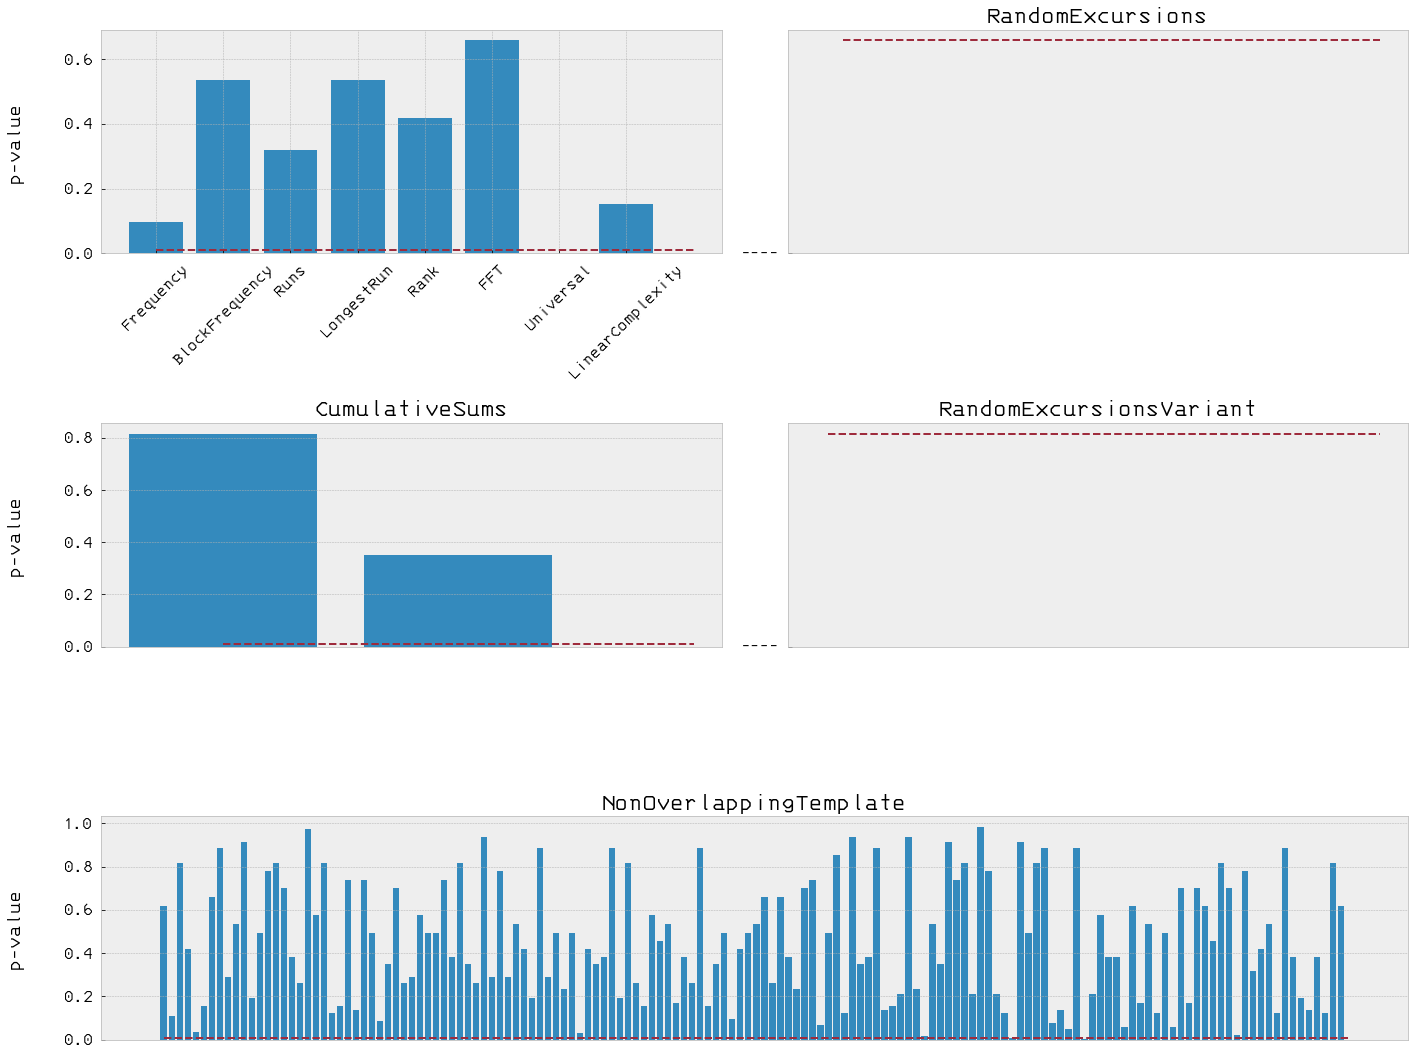

In [38]:
rcParams["figure.figsize"] = (20, 15)
nist_plot(n, m, n_param, v, "permutation")
rcParams["figure.figsize"] = (20, 8)

### Conclusion

Here we investigated three approaches to generate genuine random numbers harnessing the randomness present in Boson Samplers. Based on our simulations, we could not reproduce the results presented in [[1]](https://arxiv.org/pdf/2206.02292.pdf). Although we could generate bit streams that exhibit the same ratio between the $0$ and $1$ bits, such a bit streams did not pass the NIST STS. Due to this, the intrinsic indeterminism in generating the binary string and the fact that the von Neumann debiasing protocol requires two Fock states, we proposed another approach based on the Huffman encoding scheme. Using this approach we reached a higher bit-rate almost two times larger and replaced the bit-wise operation by a dictionary lookup to generate bit strings. In addition to those, we improved the the result of the NIST STS. Nevertheless, those improvements were not that significant in order to utilise this protocol to generate random numbers. Besides, the biggest disadvantage of this approach is that the probability distribution of the Fock states must be known initially such that those states could be encoding using the Huffman algorithm.

Finally, a new approach was proposed based the permutation symmetry in the BS architecture above. Using this method, we achived $50-50\%$ ratio between $0$ and $1$ bits and passed many of the statistical tests in NIST STS. Only a few of them were not passed due to the small number of samples. This requires a larger sample ensemble of the Fock states which will be achieved in the future.

### TODO List
1. Implement Huffman encoding scheme and the permutation symmetry for the Borealis device since there squeezed states are used as the input source of photos
2. Understand better the role of the parameters in NIST SP800-22 STS and how they affect the statistical inference
3. Analyse the bit-rate of different approaches and compare them using the Borealis device
4. Understand how we can optimise the entropy of the source by tuning tranmittivity of the beam splitters using neural network
5. Investigate the symmetry properties of the Permanent (Hafnian) and utilise it to achieve a better encoding
